# Codelab for FNN Soccer Result Prediction

### Index

1. [Pre-Processing](#Pre-processing)
2. [Recipes for Neural Nets](#Recipes-for-Neural-Nets)
3. [Start Training](#Start-Training)
4. [Observe Training Process](#Observe-Training-Process)
5. [Observe Weight Distribution](#Observe-Weight-Distribution)
6. [Define Testing Procedure](#Define-Testing-Procedure)


In [1]:
import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras.regularizers import l1, l2
from keras.utils import np_utils

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time
import pandas as pd


Using TensorFlow backend.


## Pre-processing

* proceed w/ standardizing datasets by z-scoring (de-mean, uni-variance).

* Training Data Ratio = 0.9

In [2]:
def PreprocessDataset():
    from sklearn import preprocessing
    data = pd.read_csv('Processed/cleaned_data.csv',index_col=False,low_memory=False)
    data = data.reindex(np.random.permutation(data.index))
    cols = data.columns
    x_columns = cols.drop("match_result")
    
    x = data[x_columns]
    y = data['match_result']
    
    train_max_row = int(data.shape[0]*0.9)
    
    x_train = x.iloc[:train_max_row]
    x_test = x.iloc[train_max_row:]
    
    y_train = y.iloc[:train_max_row]
    y_test = y.iloc[train_max_row:]
    
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    ################Pre-processing###########
    x_train = preprocessing.scale(x_train)
    x_test = preprocessing.scale(x_test)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = PreprocessDataset()

## Recipes for Neural Nets

* Number of Layer: 5

* Activation Fuction: ReLU

* Droupout Rate: 0.5 for 1st Layer and 0.4 for the rest four Layer

* Learning Rate: 0.005

* Weight Regularizer: None

* Optimization Methon: Adam

* Number of Batch: 128

* Number of epoch: 50



In [4]:
def DefineModel():


    activation_func = 'relu' 
    loss_function = 'categorical_crossentropy'
    #loss_function = 'mean_squared_error'
      
    dropout_rate = 0.4
    weight_regularizer = None

    learning_rate = 0.005
    
    ## Initialize model.
    model = Sequential()

    ## 1st Layer
    ## Dense' means fully-connected.
    model.add(Dense(128, input_dim=52, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(0.5))
    
    ## 2nd Layer
    model.add(Dense(64, input_dim=128, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(dropout_rate))
    
    ## 3rd Layer
    model.add(Dense(32))
    model.add(Activation(activation_func))   
    model.add(Dropout(dropout_rate))
    
    ## 4th Layer
    model.add(Dense(16))
    model.add(Activation(activation_func))   
    model.add(Dropout(dropout_rate))
    
    ## 5th Layer
    model.add(Dense(8))
    model.add(Activation(activation_func))   
    model.add(Dropout(dropout_rate))

    
    ## Adding Softmax Layer
    ## Last layer has the same dimension as the number of classes
    model.add(Dense(3))
    
    ## For classification, the activation is softmax
    model.add(Activation('softmax'))
    
    ## Define optimizer. we select Adam
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #opt = SGD(lr=learning_rate, clipnorm=5.)
    
    ## Define loss function = 'categorical_crossentropy' or 'mean_squared_error'
    model.compile(loss=loss_function, optimizer=opt, metrics=["accuracy"])

    return model

In [5]:
def TrainModel(data=None, epochs=20):

    batch=128
    start_time = time.time()
    model = DefineModel()
    if data is None:
        print("Must provide data.")
        return
    x_train, x_test, y_train, y_test = data
    print('Start training.')
    ## Use the first 55,000 (out of 60,000) samples to train, last 5,500 samples to validate.
    history = model.fit(x_train[:17500], y_train[:17500], nb_epoch=epochs, batch_size=batch,
              validation_data=(x_train[17500:], y_train[17500:]))
    print("Training took {0} seconds.".format(time.time() - start_time))
    return model, history

## Start Training

In [6]:
trained_model, training_history = TrainModel(data=[x_train, x_test, y_train, y_test],epochs = 50)

Start training.
Train on 17500 samples, validate on 2417 samples
Epoch 1/50
17500/17500 [==============================] - 1s - loss: 1.0616 - acc: 0.4574 - val_loss: 1.0088 - val_acc: 0.4936
Epoch 2/50
17500/17500 [==============================] - 0s - loss: 1.0301 - acc: 0.4874 - val_loss: 0.9998 - val_acc: 0.5139
Epoch 3/50
17500/17500 [==============================] - 0s - loss: 1.0191 - acc: 0.4991 - val_loss: 1.0002 - val_acc: 0.5168
Epoch 4/50
17500/17500 [==============================] - 0s - loss: 1.0129 - acc: 0.5009 - val_loss: 0.9902 - val_acc: 0.5225
Epoch 5/50
17500/17500 [==============================] - 0s - loss: 1.0136 - acc: 0.5013 - val_loss: 0.9933 - val_acc: 0.5118
Epoch 6/50
17500/17500 [==============================] - 0s - loss: 1.0067 - acc: 0.5063 - val_loss: 0.9937 - val_acc: 0.5188
Epoch 7/50
17500/17500 [==============================] - 0s - loss: 1.0079 - acc: 0.5038 - val_loss: 0.9830 - val_acc: 0.5279
Epoch 8/50
17500/17500 [======================

In [7]:
def PlotHistory(train_value, test_value, value_is_loss_or_acc):
    f, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ## Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc = 0) 
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)  
    


## Observe Training Process

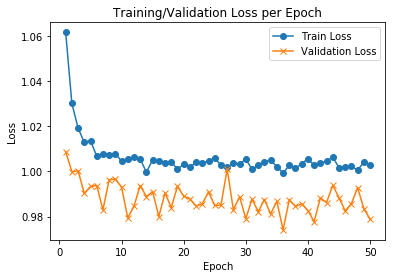

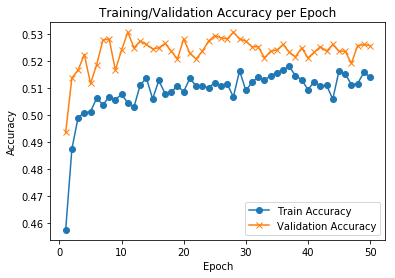

In [8]:
    
PlotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
PlotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

## Observe Weight Distribution

In [9]:
def drawWeightHistogram(x):
    ## the histogram of the data
    fig = plt.subplots()
    n, bins, patches = plt.hist(x, 50)
    plt.xlim(-0.5, 0.5)
    plt.xlabel('Weight')
    plt.ylabel('Count')
    zero_counts = (x == 0.0).sum()
    plt.title("Weight Histogram. Num of '0's: %d" % zero_counts)

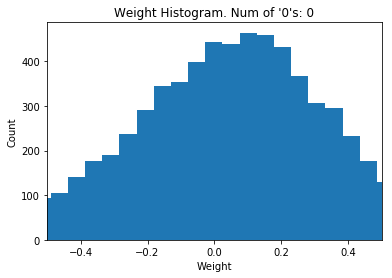

In [10]:
w1 = trained_model.layers[0].get_weights()[0].flatten()
drawWeightHistogram(w1)

## Define Testing Procedure


In [11]:
def TestModel(model=None, data=None):
    if model is None:
        print("Must provide a trained model.")
        return
    if data is None:
        print("Must provide data.")
        return
    x_test, y_test = data
    scores = model.evaluate(x_test, y_test)
    return scores

In [12]:
test_score = TestModel(model=trained_model, data=[x_test, y_test])
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

1984/2213 [=========================>....] - ETA: 0sTest loss 0.9763, accuracy 53.86%
